<a href="https://colab.research.google.com/github/DrVaishnaviKR/chlorhexidine-survival-analysis/blob/main/Chlorhexidine_Survival_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📈 Survival Analysis of Chlorhexidine Trial Outcomes Using Python**

# 1.Install required packages

In [2]:

# Run this only once. Comment out or remove in environments where packages are already installed.
!pip install lifelines matplotlib seaborn openpyxl


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 6.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=25d0f64e7ff66c5691cdf1b1e0d41d3d4597e20c9fe1865a221c047648534c6b
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


# 2.Imports and file path

In [5]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.utils import survival_table_from_events

# plotting style
plt.rcParams["figure.dpi"] = 120
sns.set(style="whitegrid")

# Path to the uploaded Excel file (same file you uploaded). See citation.
DATA_PATH = "Chlorhexidine Trials.xlsx"  # adjust if needed
print("Data path set to:", DATA_PATH)


Data path set to: Chlorhexidine Trials.xlsx


# 3.Load dataset for overview

In [6]:

df = pd.read_excel(DATA_PATH)
print("Rows Columns:", df.shape)
display(df.head())
print("\nColumn types:\n", df.dtypes)


Rows Columns: (99, 12)


,trial_arm,Age,Gender,event,chest_xray,cpis,time,culture,ulcer,apache_score,tlc_score,microbial_load
0,1,49,Male,0,0,0,5,1,0,11,10980.000000,50.0
1,1,72,Male,0,0,0,6,0,0,17,12366.666667,50.0
2,1,72,Male,0,1,0,8,1,0,16,26475.000000,50.0
3,1,55,Female,0,1,0,10,1,0,29,7200.000000,200.0
4,1,20,Male,0,0,0,6,0,0,18,8500.000000,90.0



Column types:
 trial_arm           int64
Age                 int64
Gender             object
event               int64
chest_xray          int64
cpis                int64
time                int64
culture             int64
ulcer               int64
apache_score        int64
tlc_score         float64
microbial_load    float64
dtype: object


# 4.Standardize data

In [7]:


df = df.copy()
rename_map = {
    "Age": "Age",
    "Gender": "Gender",
    "Event": "event",
    "VAP_event": "event",
    "time": "time",
    "Time": "time",
    "Chest Xray": "chest_xray",
    "Chest_Xray": "chest_xray",
    "Chest xray": "chest_xray",
    "CPIS": "cpis",
    "CPIS_score": "cpis",
    "Culture": "culture",
    "culture_result": "culture",
    "Ulcer": "ulcer",
    "Oral Ulcer": "ulcer",
    "APACHE Score": "apache_score",
    "APACHE II Score": "apache_score",
    "APACHEII": "apache_score",
    "TLC": "tlc_score",
    "TLC_Day1": "tlc_score",
    "TLC Day 1": "tlc_score",
    "Oral microbial load": "microbial_load",
    "Microbial Load": "microbial_load",
    "microbial_load": "microbial_load",
    "trial_arm": "trial_arm"  # ensure trial_arm passes through if already named
}

# Apply rename only for keys present
rename_actual = {k: v for k, v in rename_map.items() if k in df.columns}
df.rename(columns=rename_actual, inplace=True)

# Required columns for later Cox step (we will adapt if some missing)
required_cols = [
    "Age", "Gender", "event", "chest_xray", "cpis", "time",
    "culture", "ulcer", "apache_score", "tlc_score", "microbial_load"
]
missing = [c for c in required_cols if c not in df.columns]

if missing:
    print("Warning: the following expected model columns are missing:", missing)
    print("Proceeding with available columns and will impute or skip where necessary.")
else:
    print("All required columns detected.")


All required columns detected.


# 5.Standardize of Data





In [9]:

numeric_cols = ["time", "event", "cpis", "apache_score", "tlc_score", "microbial_load", "Age"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Event must be 0/1; coerce and fill missing as 0 if ambiguous
if "event" in df.columns:
    df["event"] = df["event"].fillna(0).astype(int)

# Standardize Gender strings to lowercase trimmed text
if "Gender" in df.columns:
    df["Gender"] = df["Gender"].astype(str).str.strip().str.lower().replace({"nan": np.nan})

# Quick peek at the canonical columns (only show those that exist)
display(df[[c for c in required_cols if c in df.columns]].head())
print("\nMissing by column (selected):")
print(df[[c for c in required_cols if c in df.columns]].isna().sum())


,Age,Gender,event,chest_xray,cpis,time,culture,ulcer,apache_score,tlc_score,microbial_load
0,49,male,0,0,0,5,1,0,11,10980.000000,50.0
1,72,male,0,0,0,6,0,0,17,12366.666667,50.0
2,72,male,0,1,0,8,1,0,16,26475.000000,50.0
3,55,female,0,1,0,10,1,0,29,7200.000000,200.0
4,20,male,0,0,0,6,0,0,18,8500.000000,90.0



Missing by column (selected):
Age               0
Gender            0
event             0
chest_xray        0
cpis              0
time              0
culture           0
ulcer             0
apache_score      0
tlc_score         0
microbial_load    3
dtype: int64


# 6.Baseline summary and exploratory plots

Baseline summary


,0
Total N,99
Events count,7
Time mean (SD),5.9 (2.3)
Age mean (SD),47.1 (17.1)
APACHE mean (SD),17.1 (6.7)


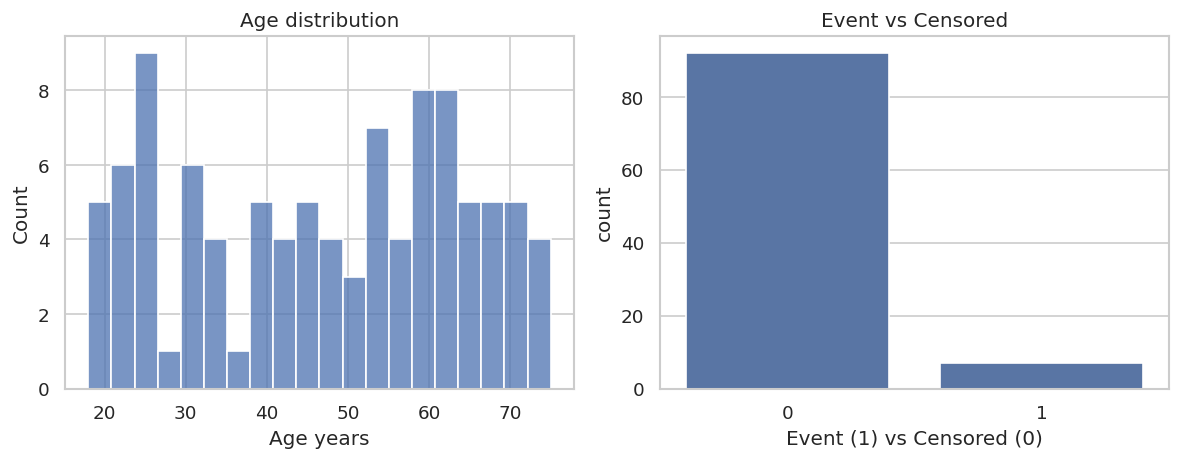

In [10]:

def baseline_summary(df):
    n = len(df)
    events = int(df["event"].sum()) if "event" in df.columns else np.nan
    return pd.Series({
        "Total N": n,
        "Events count": events,
        "Time mean (SD)": f"{df['time'].mean():.1f} ({df['time'].std():.1f})" if "time" in df.columns else None,
        "Age mean (SD)": f"{df['Age'].mean():.1f} ({df['Age'].std():.1f})" if "Age" in df.columns else None,
        "APACHE mean (SD)": f"{df['apache_score'].mean():.1f} ({df['apache_score'].std():.1f})" if "apache_score" in df.columns else None
    })

print("Baseline summary")
display(baseline_summary(df))

# Simple EDA plots: Age distribution and event counts
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
if "Age" in df.columns:
    sns.histplot(df["Age"].dropna(), bins=20)
    plt.title("Age distribution")
    plt.xlabel("Age years")
else:
    plt.text(0.5, 0.5, "Age not present", ha="center", va="center")

plt.subplot(1,2,2)
if "event" in df.columns:
    sns.countplot(x="event", data=df)
    plt.title("Event vs Censored")
    plt.xlabel("Event (1) vs Censored (0)")
else:
    plt.text(0.5, 0.5, "Event not present", ha="center", va="center")
plt.tight_layout()
plt.show()


# 6.Kaplan Meier estimation overall and by trial arm

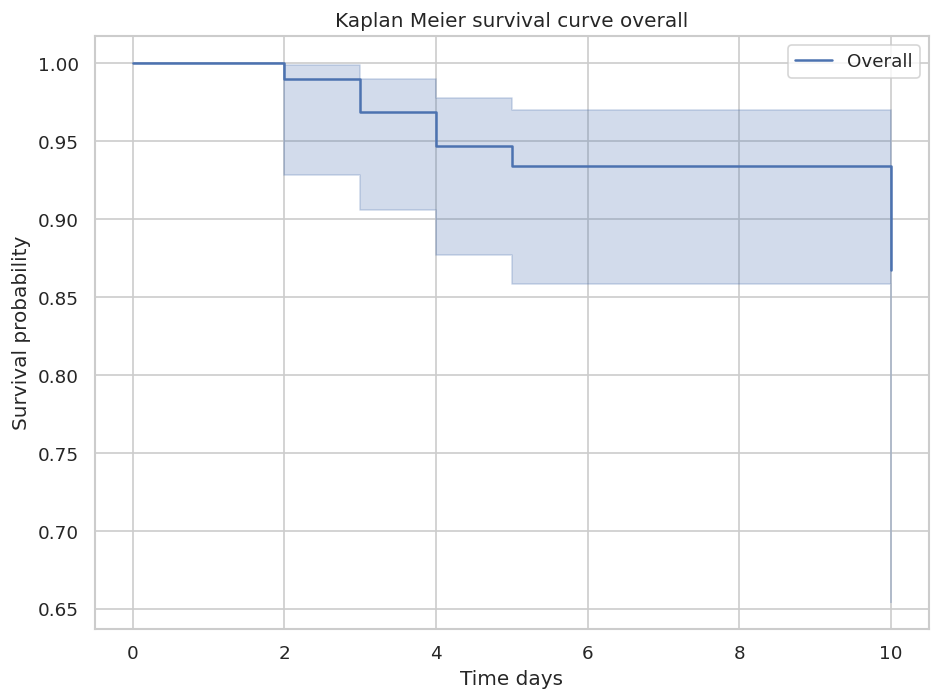

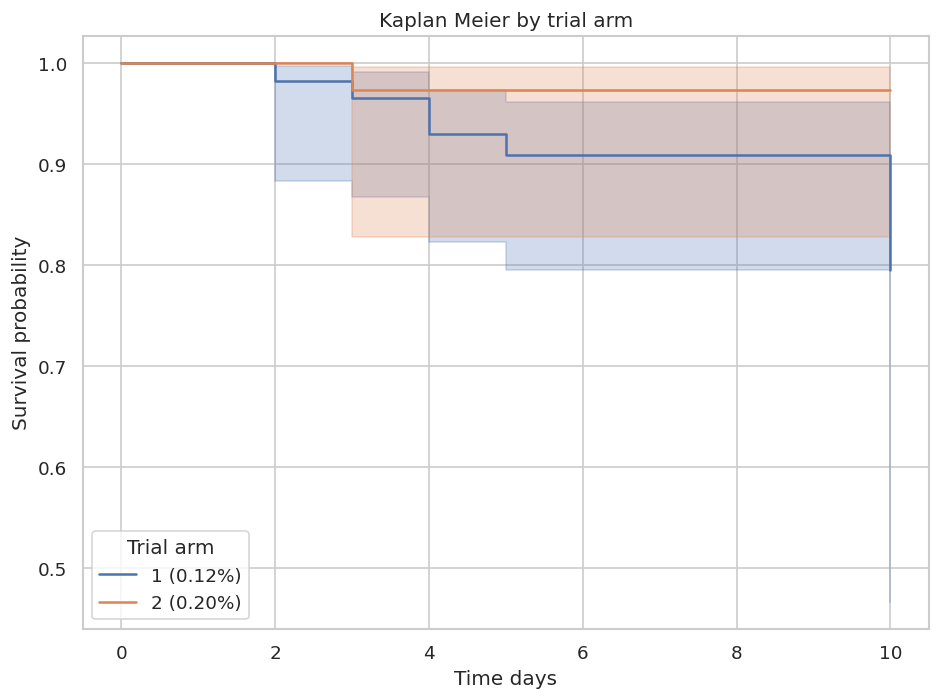

Survival probabilities at chosen times (days)
1 {5: 0.9092551938316557, 10: 0.7955982946026987, 20: 0.7955982946026987, 30: 0.7955982946026987}
2 {5: 0.9736842105263158, 10: 0.9736842105263158, 20: 0.9736842105263158, 30: 0.9736842105263158}


In [11]:

# Overall KM
kmf = KaplanMeierFitter()
plt.figure(figsize=(8,6))
kmf.fit(df["time"], event_observed=df["event"], label="Overall")
ax = kmf.plot(ci_show=True)
plt.title("Kaplan Meier survival curve overall")
plt.xlabel("Time days")
plt.ylabel("Survival probability")
plt.grid(True)
plt.tight_layout()
plt.show()

# By trial arm if present
if "trial_arm" in df.columns:
    arms = df["trial_arm"].dropna().unique()
    plt.figure(figsize=(8,6))
    km_by_arm = {}

    # Custom label map
    label_map = {
        1: "1 (0.12%)",
        2: "2 (0.20%)"
    }

    for arm in arms:
        mask = df["trial_arm"] == arm
        km = KaplanMeierFitter()

        km.fit(
            df.loc[mask, "time"],
            event_observed=df.loc[mask, "event"],
            label=label_map.get(arm, str(arm))
        )

        km.plot_survival_function(ci_show=True)
        km_by_arm[arm] = km

    plt.title("Kaplan Meier by trial arm")
    plt.xlabel("Time days")
    plt.ylabel("Survival probability")
    plt.legend(title="Trial arm")
    plt.tight_layout()
    plt.show()

    # Print survival probabilities at some timepoints for each arm
    times_to_report = [5, 10, 20, 30]  # adjust as needed
    print("Survival probabilities at chosen times (days)")
    for arm, km in km_by_arm.items():
        probs = {}
        for t in times_to_report:
            try:
                probs[t] = float(km.survival_function_at_times(t).iloc[0])
            except Exception:
                probs[t] = np.nan
        print(arm, probs)
else:
    print("trial_arm column not found. KM by arm skipped.")

# 7.Log rank test

In [12]:

from itertools import combinations

# Detect arms safely
arms = df["trial_arm"].dropna().unique().tolist() if "trial_arm" in df.columns else []
print("Detected arms:", arms)

def compute_lr(a, b):
    gA = df[df["trial_arm"] == a]
    gB = df[df["trial_arm"] == b]
    lr = logrank_test(gA["time"], gB["time"], event_observed_A=gA["event"], event_observed_B=gB["event"])
    return {
        "Arm A": a,
        "Arm B": b,
        "Chi Square": float(lr.test_statistic),
        "Degrees of Freedom": 1,
        "p Value": float(lr.p_value)
    }

if len(arms) == 0:
    print("No trial_arm values found.")
elif len(arms) == 1:
    print("Only one arm present; log-rank requires two or more.")
elif len(arms) == 2:
    res = compute_lr(arms[0], arms[1])
    lr_table = pd.DataFrame([res])
    print("\nLog Rank Chi Square Table")
    display(lr_table)
    lr_table.to_csv("logrank_two_arm_table.csv", index=False)
    print("Saved: logrank_two_arm_table.csv")
else:
    # Pairwise comparisons with Bonferroni correction
    results = []
    for a, b in combinations(arms, 2):
        results.append(compute_lr(a, b))
    lr_table = pd.DataFrame(results)
    lr_table["Bonferroni p"] = (lr_table["p Value"] * len(lr_table)).clip(upper=1.0)
    lr_table = lr_table.sort_values("p Value").reset_index(drop=True)
    print("\nPairwise Log Rank Test Table (sorted by p Value)")
    display(lr_table)
    lr_table.to_csv("logrank_pairwise_table.csv", index=False)
    print("Saved: logrank_pairwise_table.csv")


Detected arms: [1, 2]

Log Rank Chi Square Table


,Arm A,Arm B,Chi Square,Degrees of Freedom,p Value
0,1,2,1.938268,1,0.163857


Saved: logrank_two_arm_table.csv


# 8.Prepare covariates for Cox model

In [13]:

# Target covariates you requested: Age Gender event chest_xray cpis time culture ulcer apache_score tlc_score microbial_load
cox_vars = ["time","event","Age","Gender","chest_xray","cpis","culture","ulcer","apache_score","tlc_score","microbial_load"]
cox_present = [c for c in cox_vars if c in df.columns]
cox_df = df[cox_present].copy()
print("Columns used for Cox model:", cox_present)
display(cox_df.head())
print("\nMissing values (before imputation):")
print(cox_df.isna().sum())


Columns used for Cox model: ['time', 'event', 'Age', 'Gender', 'chest_xray', 'cpis', 'culture', 'ulcer', 'apache_score', 'tlc_score', 'microbial_load']


,time,event,Age,Gender,chest_xray,cpis,culture,ulcer,apache_score,tlc_score,microbial_load
0,5,0,49,male,0,0,1,0,11,10980.000000,50.0
1,6,0,72,male,0,0,0,0,17,12366.666667,50.0
2,8,0,72,male,1,0,1,0,16,26475.000000,50.0
3,10,0,55,female,1,0,1,0,29,7200.000000,200.0
4,6,0,20,male,0,0,0,0,18,8500.000000,90.0



Missing values (before imputation):
time              0
event             0
Age               0
Gender            0
chest_xray        0
cpis              0
culture           0
ulcer             0
apache_score      0
tlc_score         0
microbial_load    3
dtype: int64


# 9.Encode categorical predictors and convert to numeric matrix

In [14]:

if "Gender" in cox_df.columns:
    unique_g = cox_df["Gender"].dropna().unique()
    normalized = set([str(x).lower() for x in unique_g])
    if normalized.issubset({"male","female","m","f","man","woman"}):
        cox_df["Gender_bin"] = cox_df["Gender"].astype(str).str.lower().map(lambda x: 1 if "m" in x else 0)
        cox_df.drop(columns=["Gender"], inplace=True)
    else:
        g_dummies = pd.get_dummies(cox_df["Gender"], prefix="Gender", drop_first=True)
        cox_df = pd.concat([cox_df.drop(columns=["Gender"]), g_dummies], axis=1)

# Convert potential text flags into binary flags for chest_xray, culture, ulcer
def to_flag(series):
    if series.dtype == object:
        s = series.astype(str).str.lower()
        return s.map(lambda x: 1 if any(k in x for k in ["yes","y","positive","pos","1","present","infiltrate","infiltrates","true"]) else 0)
    else:
        return pd.to_numeric(series, errors="coerce").fillna(0).astype(int)

for col in ["chest_xray","culture","ulcer"]:
    if col in cox_df.columns:
        if cox_df[col].dtype == object:
            cox_df[col] = to_flag(cox_df[col])
        else:
            cox_df[col] = pd.to_numeric(cox_df[col], errors="coerce").fillna(0).astype(int)

# Ensure all covariates (except time/event) are numeric
for c in cox_df.columns:
    if c not in ["time","event"]:
        cox_df[c] = pd.to_numeric(cox_df[c], errors="coerce")

display(cox_df.head())
print("\nMissing values after encoding:")
print(cox_df.isna().sum())


,time,event,Age,chest_xray,cpis,culture,ulcer,apache_score,tlc_score,microbial_load,Gender_bin
0,5,0,49,0,0,1,0,11,10980.000000,50.0,1
1,6,0,72,0,0,0,0,17,12366.666667,50.0,1
2,8,0,72,1,0,1,0,16,26475.000000,50.0,1
3,10,0,55,1,0,1,0,29,7200.000000,200.0,1
4,6,0,20,0,0,0,0,18,8500.000000,90.0,1



Missing values after encoding:
time              0
event             0
Age               0
chest_xray        0
cpis              0
culture           0
ulcer             0
apache_score      0
tlc_score         0
microbial_load    3
Gender_bin        0
dtype: int64


#10.Missing values Imputation

In [15]:

if cox_df[["time","event"]].isna().any().any():
    raise ValueError("time or event columns contain missing values. Fix before modeling.")

# Impute other columns
for col in cox_df.columns:
    if col in ["time","event"]:
        continue
    if cox_df[col].isna().sum() > 0:
        if pd.api.types.is_numeric_dtype(cox_df[col]):
            med = cox_df[col].median()
            cox_df[col].fillna(med, inplace=True)
            print(f"Imputed numeric {col} with median {med}")
        else:
            mode = cox_df[col].mode(dropna=True)
            fill = mode.iloc[0] if not mode.empty else 0
            cox_df[col].fillna(fill, inplace=True)
            print(f"Imputed non-numeric {col} with mode {fill}")

print("\nMissing values after imputation:")
print(cox_df.isna().sum())


Imputed numeric microbial_load with median 200.0

Missing values after imputation:
time              0
event             0
Age               0
chest_xray        0
cpis              0
culture           0
ulcer             0
apache_score      0
tlc_score         0
microbial_load    0
Gender_bin        0
dtype: int64


/tmp/ipython-input-2566928968.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cox_df[col].fillna(med, inplace=True)


# 11.Interpretation of Cox Model Variables

Variance of predictors:
Age               2.924875e+02
chest_xray        1.855288e-01
cpis              4.844362e-02
culture           2.451041e-01
ulcer             0.000000e+00
apache_score      4.529582e+01
tlc_score         2.641749e+07
microbial_load    2.414560e+04
Gender_bin        0.000000e+00
dtype: float64
Low variance columns to drop: ['cpis', 'ulcer', 'Gender_bin']
Columns remaining for Cox model: ['time', 'event', 'Age', 'chest_xray', 'culture', 'apache_score', 'tlc_score', 'microbial_load']


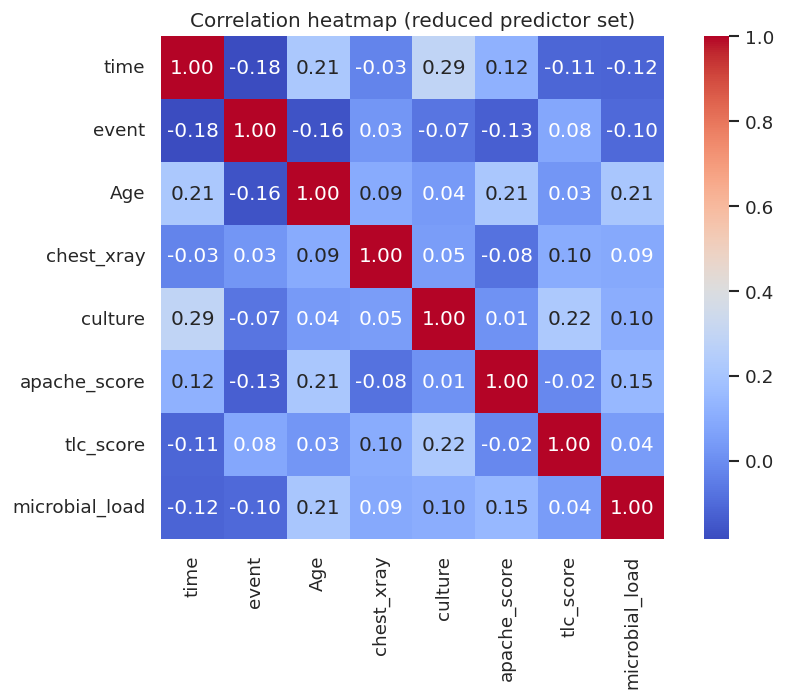

In [16]:

variances = cox_df.drop(columns=["time","event"]).var()
print("Variance of predictors:")
print(variances)

# Threshold for dropping very low variance columns (adjustable)
low_var_threshold = 0.05
low_var_cols = variances[variances < low_var_threshold].index.tolist()
print("Low variance columns to drop:", low_var_cols)

# Drop them to improve model convergence
cox_df_reduced = cox_df.drop(columns=low_var_cols).copy()
print("Columns remaining for Cox model:", cox_df_reduced.columns.tolist())

# Correlation heatmap to inspect collinearity (visual check)
corr = cox_df_reduced.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation heatmap (reduced predictor set)")
plt.tight_layout()
plt.show()


# 12.Fit Cox Proportional Hazards model

In [17]:

cph = CoxPHFitter()
cph.fit(cox_df_reduced, duration_col="time", event_col="event")
print("Cox PH fitted on reduced predictor set")
cph.print_summary()


Cox PH fitted on reduced predictor set


<lifelines.CoxPHFitter: fitted with 99 total observations, 92 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 99
number of events observed = 7
   partial log-likelihood = -26.15
         time fit was run = 2025-11-25 18:11:26 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
Age            -0.03      0.97      0.03           -0.08            0.02                0.92                1.02
chest_xray      0.47      1.60      0.94           -1.37            2.30                0.25               10.00
culture        -1.06      0.35      0.90           -2.82            0.70                0.06                2.01
apache_score   -0.07      0.93      0.07           -0.20            0.06                0.82                1.06
tlc_score       0.00      1.00      0.00           -0.00            0.00                1.00                1.00
microbial_load -0.00      1.00      0.00           -0.01            0.01                0.99                1.01

                cmp to     z    p  -log2(p)
covariate                                  
Age               0.00 -1.27 0.21      2.28
chest_xray        0.00  0.50 0.62      0.69
culture           0.00 -1.18 0.24      2.08
apache_score      0.00 -1.06 0.29      1.80
tlc_score         0.00  1.30 0.19      2.36
microbial_load    0.00 -0.59 0.56      0.84
---
Concordance = 0.80
Partial AIC = 64.31
log-likelihood ratio test = 6.79 on 6 df
-log2(p) of ll-ratio test = 1.55

# 13.Hazard Ratio table

In [18]:

hr_table = cph.summary.reset_index()[[
    "covariate",
    "exp(coef)",
    "exp(coef) lower 95%",
    "exp(coef) upper 95%",
    "p"
]]
hr_table.columns = ["Variable", "HR", "Lower95", "Upper95", "p_value"]
display(hr_table)
hr_table.to_csv("cox_hr_table_final.csv", index=False)
print("Saved: cox_hr_table_final.csv")


,Variable,HR,Lower95,Upper95,p_value
0,Age,0.967836,0.920065,1.018087,0.205555
1,chest_xray,1.595219,0.254346,10.004951,0.618115
2,culture,0.345271,0.059329,2.009347,0.236644
3,apache_score,0.932779,0.820550,1.060358,0.287365
4,tlc_score,1.000078,0.999960,1.000195,0.194690
5,microbial_load,0.997707,0.990093,1.005379,0.556922


Saved: cox_hr_table_final.csv


# 14.Schoenfeld Residual Plots (PH Assumption Test)



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.88178e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.23358e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.12758e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.70394e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.12758e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.94746e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.88178e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.88178e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


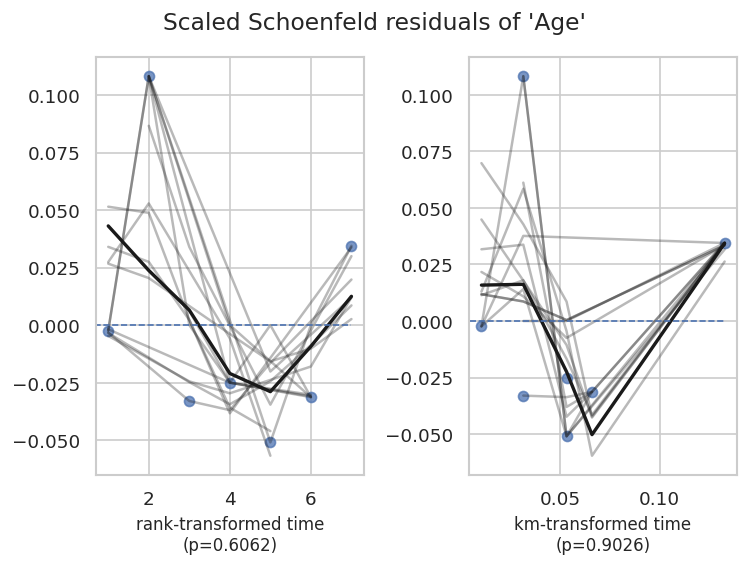

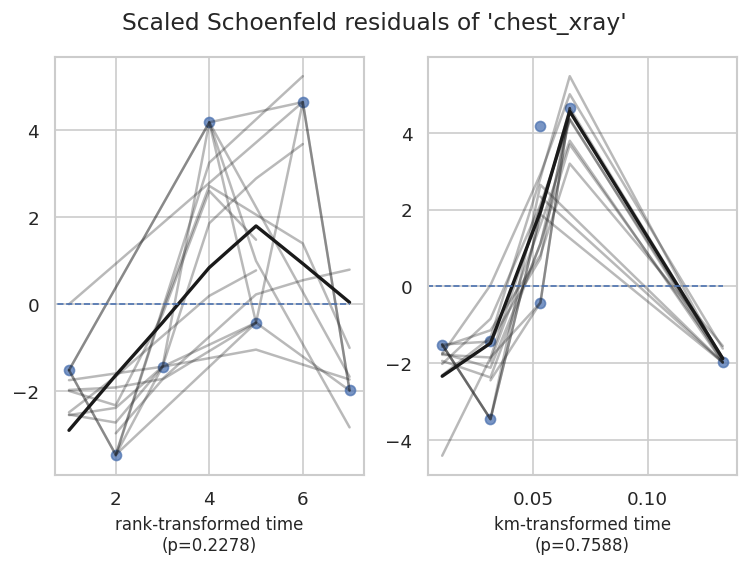

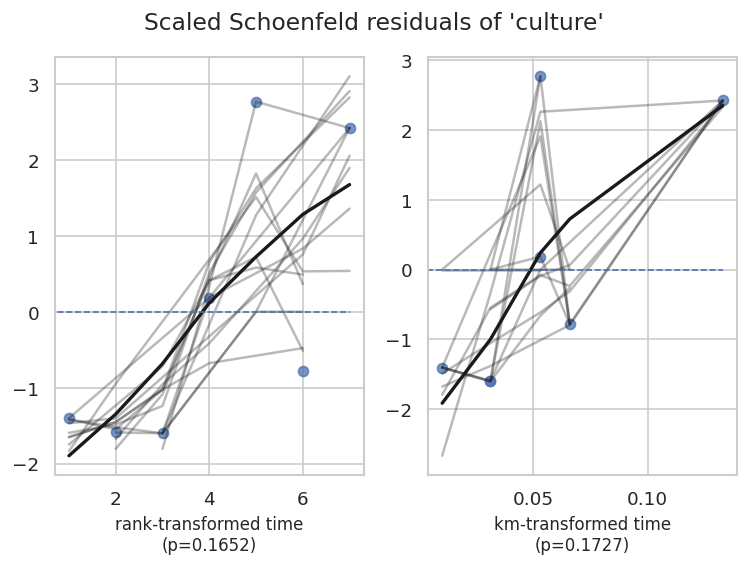

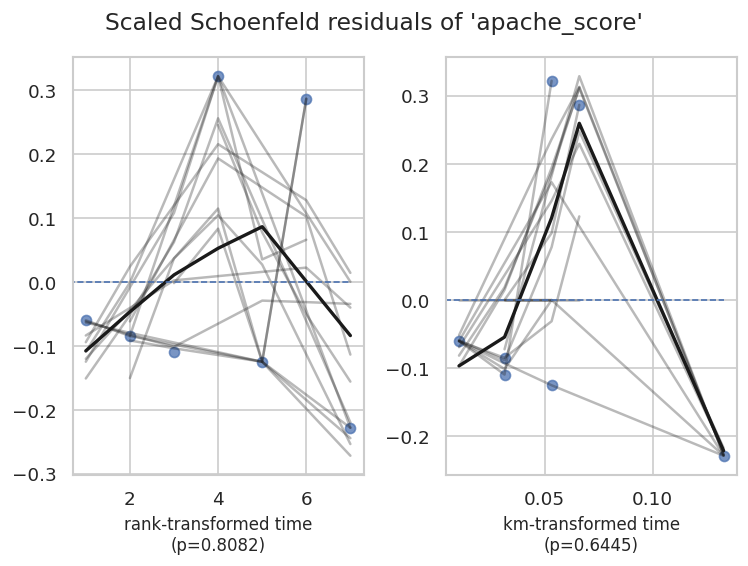

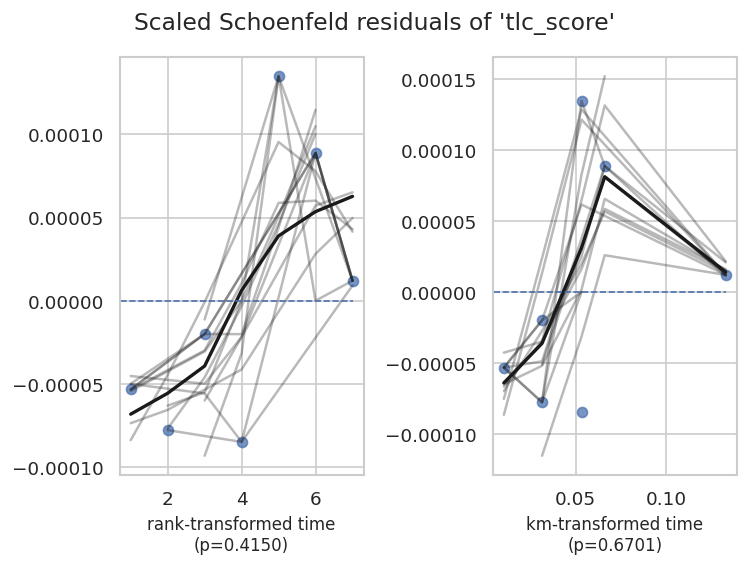

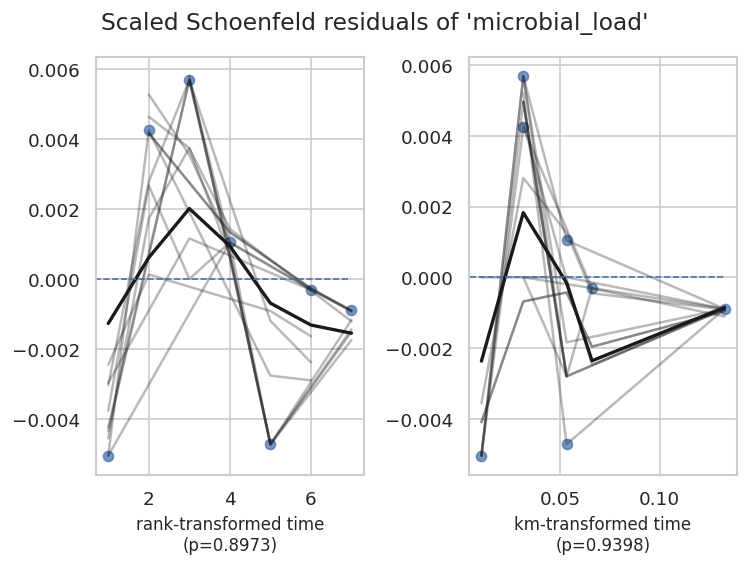

In [19]:

cox_df_model = cox_df_reduced  # explicit
try:
    cph.check_assumptions(cox_df_model, p_value_threshold=0.05, show_plots=True)
except Exception as e:
    print("check_assumptions raised:", type(e).__name__, str(e))
    # fallback to global proportional hazards test
    from lifelines.statistics import proportional_hazard_test
    res = proportional_hazard_test(cph, cox_df_model, time_transform='rank')
    print(res.summary)


# 15.Nelson Aalen cumulative hazard and forest plot for HR

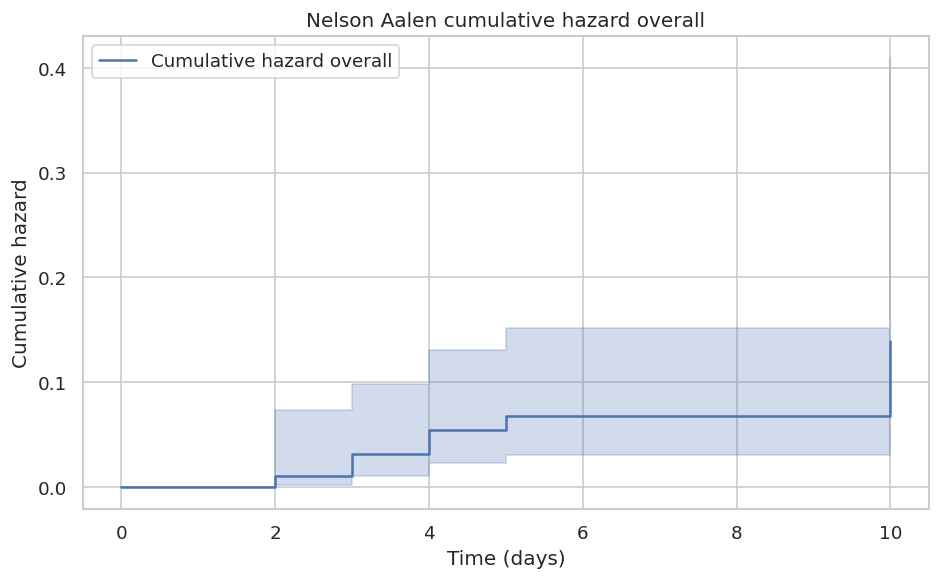

Saved plot: nelson_aalen_cumulative_hazard.png


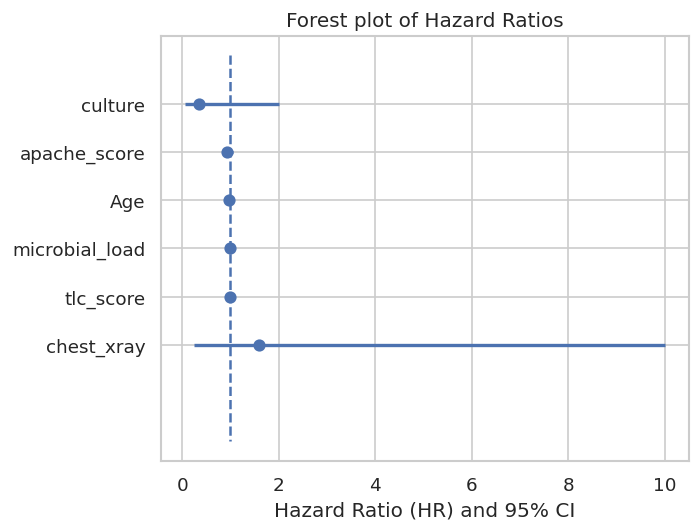

Saved plot: cox_forest_plot_hr.png


In [20]:
# Cell 15 Nelson Aalen cumulative hazard and forest plot for HR
from lifelines import NelsonAalenFitter
import numpy as np

# Nelson Aalen cumulative hazard overall (use original df for overall)
naf = NelsonAalenFitter()
naf.fit(df["time"], event_observed=df["event"], label="Cumulative hazard overall")
plt.figure(figsize=(8,5))
naf.plot(ci_show=True)
plt.title("Nelson Aalen cumulative hazard overall")
plt.xlabel("Time (days)")
plt.ylabel("Cumulative hazard")
plt.tight_layout()
plt.savefig("nelson_aalen_cumulative_hazard.png", dpi=150)
plt.show()
print("Saved plot: nelson_aalen_cumulative_hazard.png")

# Forest plot for Hazard Ratios from cph.summary
summary = cph.summary.reset_index().copy()
summary["HR"] = summary["exp(coef)"]
summary["HR_lower"] = summary["exp(coef) lower 95%"]
summary["HR_upper"] = summary["exp(coef) upper 95%"]
summary_plot = summary.sort_values("HR")

plt.figure(figsize=(6, 0.6*len(summary_plot) + 1))
y = np.arange(len(summary_plot))
plt.hlines(y, summary_plot["HR_lower"], summary_plot["HR_upper"], linewidth=2)
plt.scatter(summary_plot["HR"], y, s=40, zorder=3)
plt.vlines(1, -1, len(summary_plot)+1, linestyles="dashed")
plt.yticks(y, summary_plot["covariate"])
plt.xlabel("Hazard Ratio (HR) and 95% CI")
plt.gca().invert_yaxis()
plt.title("Forest plot of Hazard Ratios")
plt.tight_layout()
plt.savefig("cox_forest_plot_hr.png", dpi=150)
plt.show()
print("Saved plot: cox_forest_plot_hr.png")


## 16.Event distribution chart and save model outputs

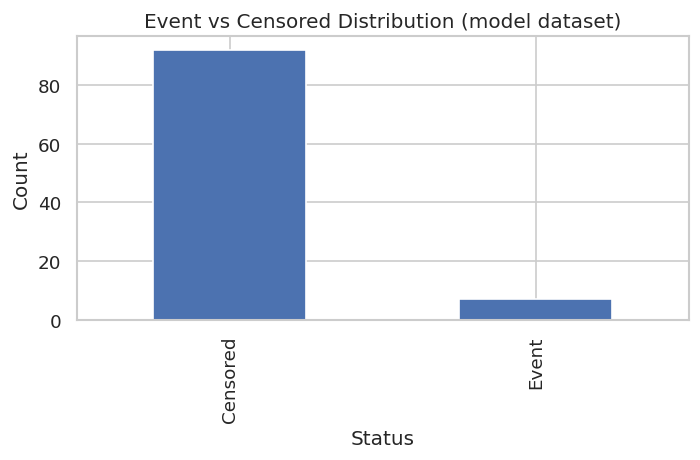

Saved plot: event_distribution.png
Saved: cox_summary_full.csv and cox_data_used_for_model.csv


In [21]:

plt.figure(figsize=(6,4))
cox_df_model["event"].value_counts().rename(index={1:"Event", 0:"Censored"}).plot(kind="bar")
plt.title("Event vs Censored Distribution (model dataset)")
plt.ylabel("Count")
plt.xlabel("Status")
plt.tight_layout()
plt.savefig("event_distribution.png", dpi=150)
plt.show()
print("Saved plot: event_distribution.png")

# Save Cox summary and data used for reproducibility
cph.summary.to_csv("cox_summary_full.csv")
cox_df_model.to_csv("cox_data_used_for_model.csv", index=False)
print("Saved: cox_summary_full.csv and cox_data_used_for_model.csv")


# 17.Adjusted Survival Curves for all variables

Covariates in Cox model: ['Age', 'chest_xray', 'culture', 'apache_score', 'tlc_score', 'microbial_load']

Generating adjusted survival curves for: Age


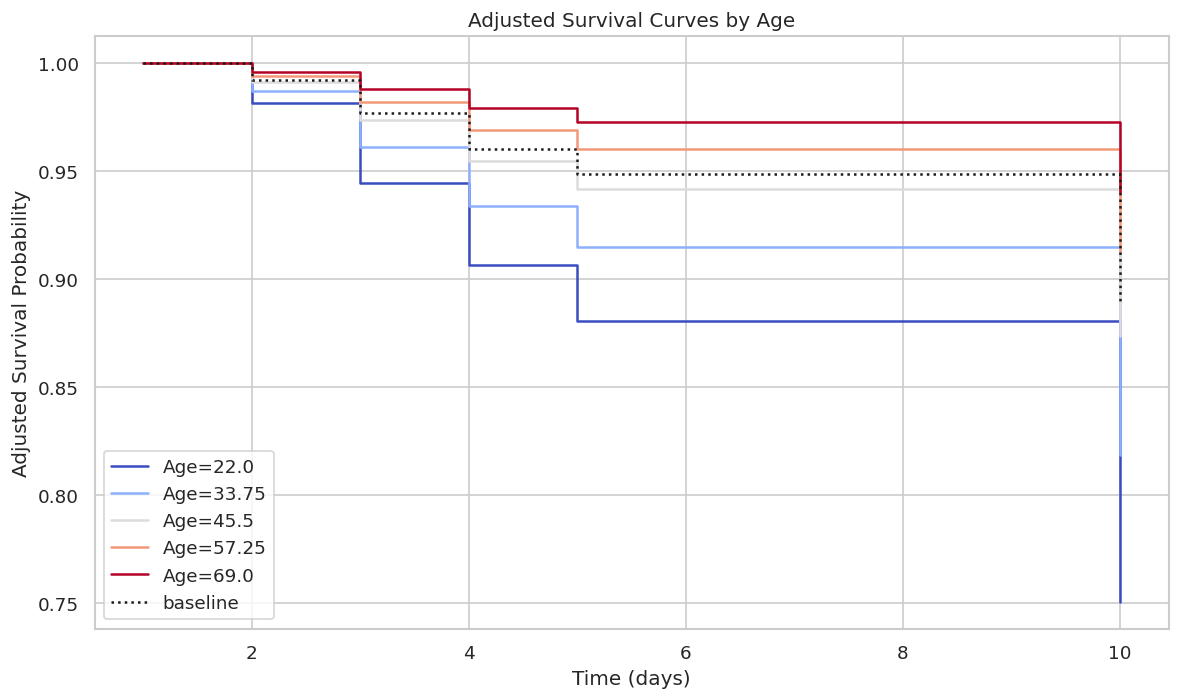


Generating adjusted survival curves for: chest_xray


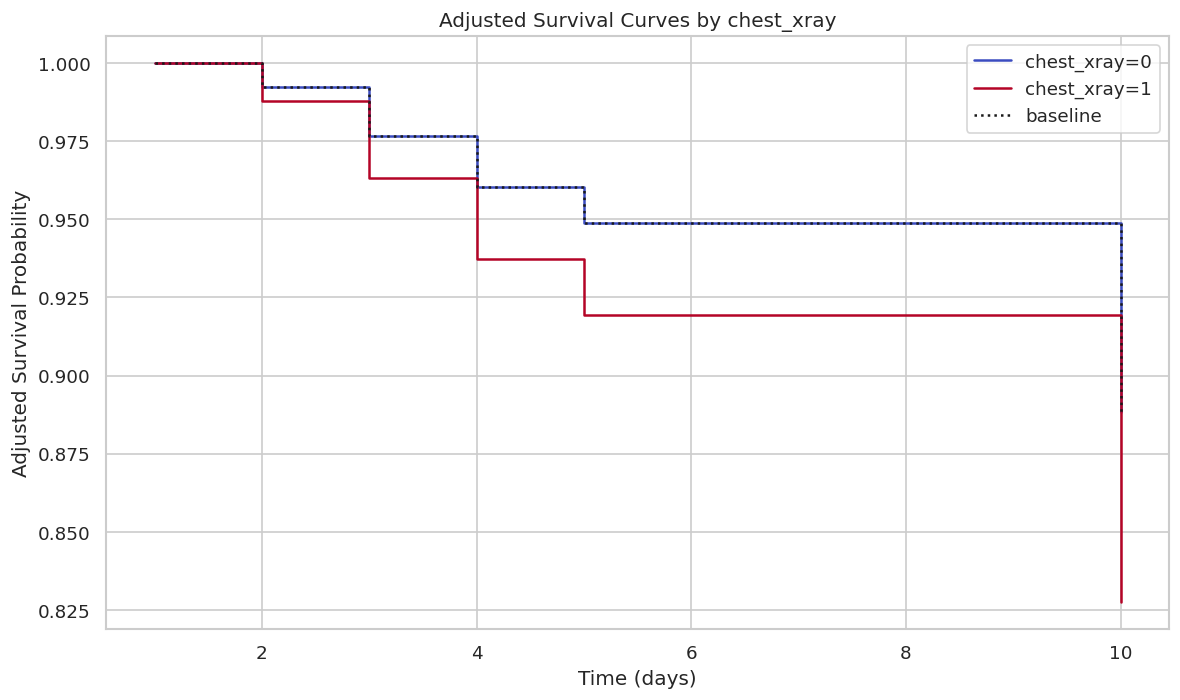


Generating adjusted survival curves for: culture


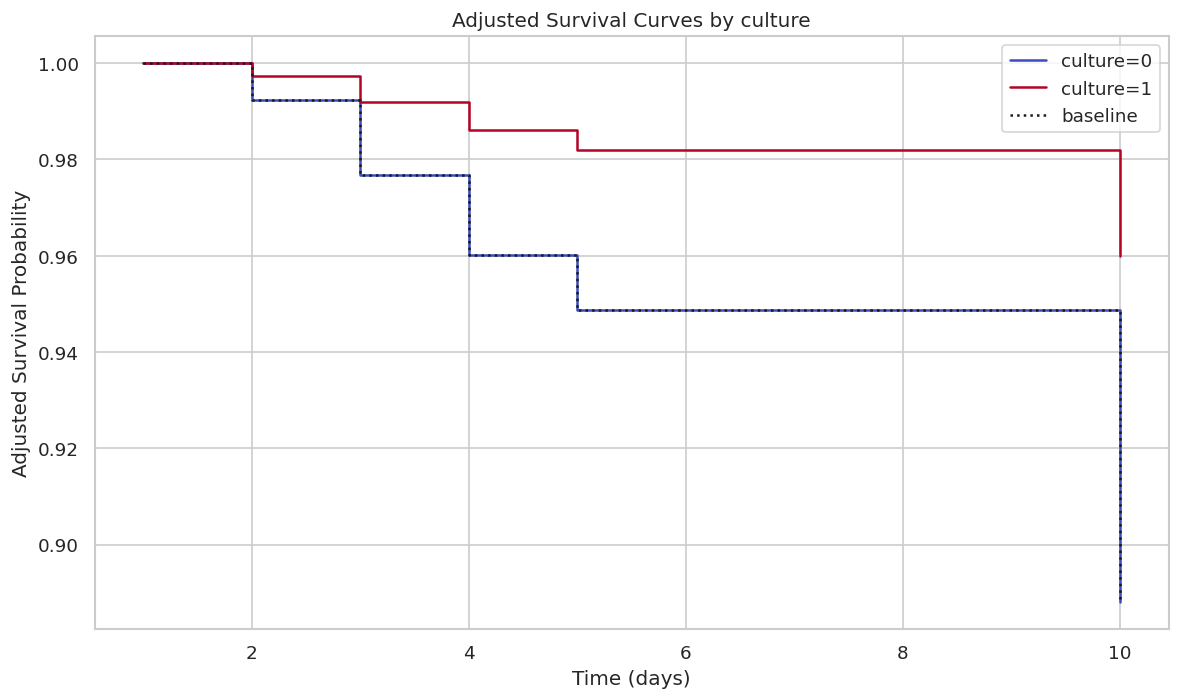


Generating adjusted survival curves for: apache_score


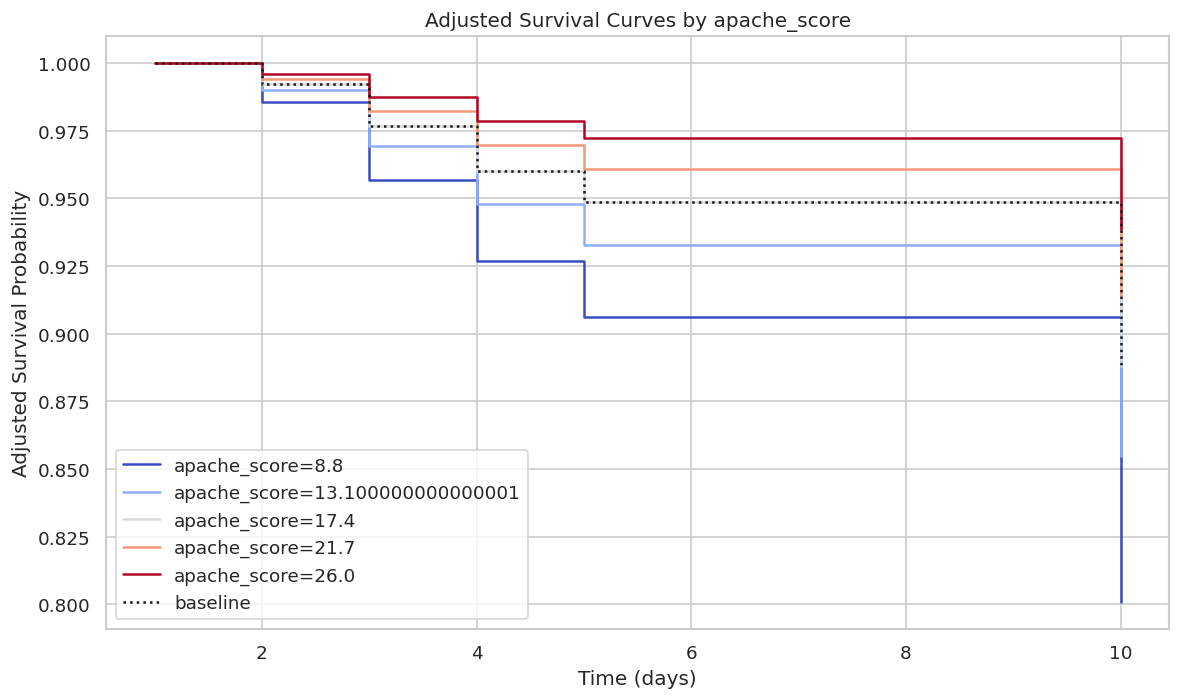


Generating adjusted survival curves for: tlc_score


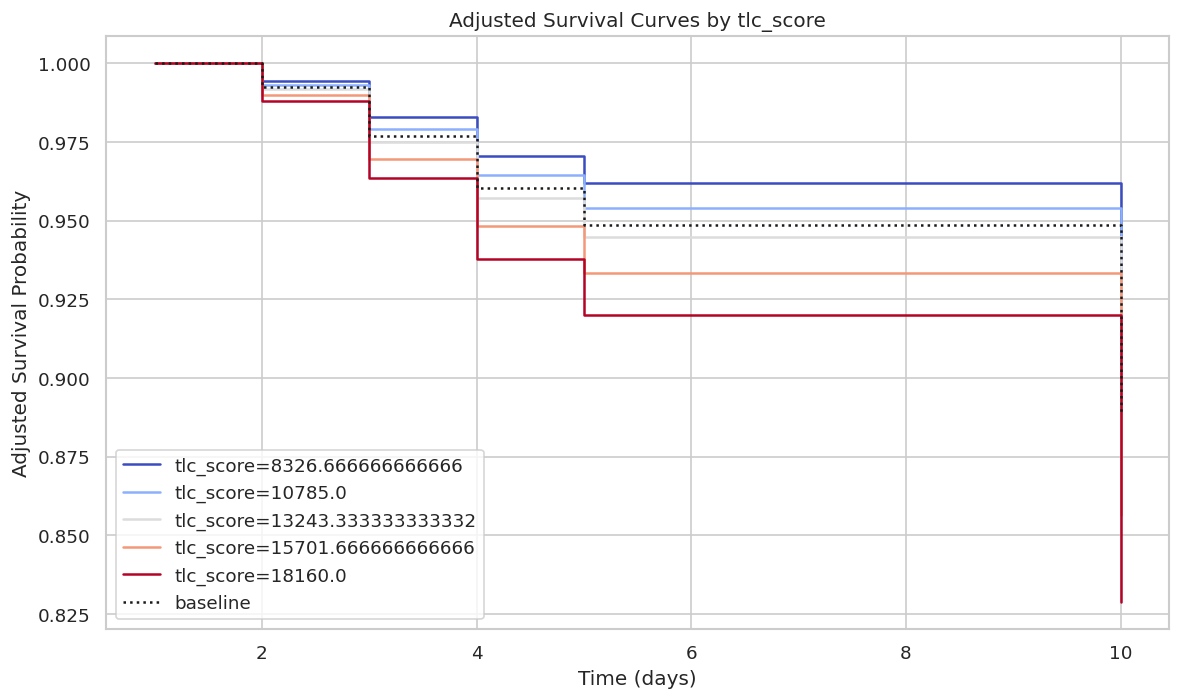


Generating adjusted survival curves for: microbial_load


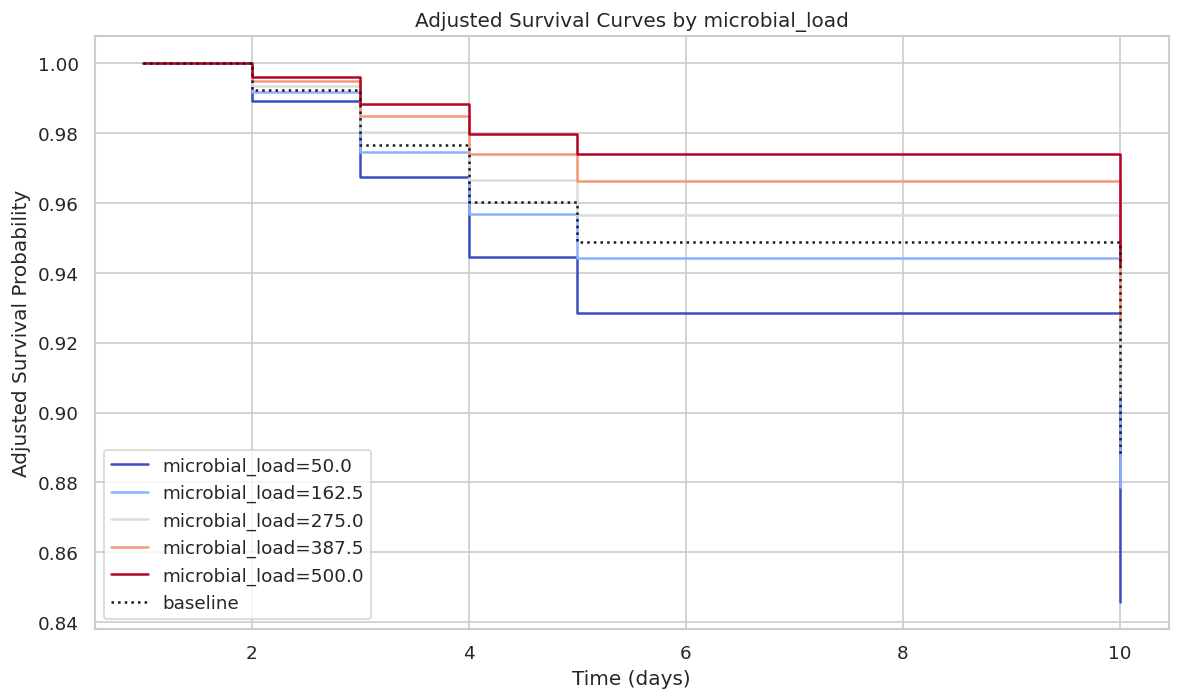

In [22]:

covariates = list(cph.params_.index)
print("Covariates in Cox model:", covariates)

for cov in covariates:
    print(f"\nGenerating adjusted survival curves for: {cov}")

    series = cox_df_reduced[cov]

    # Check numeric vs binary vs categorical
    unique_vals = np.sort(series.dropna().unique())

    # Case 1: Binary variable
    if set(unique_vals).issubset({0, 1}):
        values = [0, 1]

    # Case 2: Continuous numeric
    elif pd.api.types.is_numeric_dtype(series):
        # Pick a reasonable range for plotting
        low = np.nanpercentile(series, 10)
        high = np.nanpercentile(series, 90)
        # 5-point spread
        values = np.linspace(low, high, 5)

    # Case 3: Multi-level category / one-hot encoded
    else:
        values = unique_vals.tolist()

    # Plot partial effects
    fig, ax = plt.subplots(figsize=(10, 6))
    try:
        cph.plot_partial_effects_on_outcome(
            covariates=cov,
            values=values,
            cmap="coolwarm",
            ax=ax
        )
    except Exception as e:
        print(f"Skipping {cov}, plot_partial_effects failed:", str(e))
        plt.close()
        continue

    plt.title(f"Adjusted Survival Curves by {cov}")
    plt.xlabel("Time (days)")
    plt.ylabel("Adjusted Survival Probability")
    plt.grid(True)
    plt.tight_layout()
    plt.show()